# Overview
*BeamNG.tech / BeamNG.drive (partially)*

This example will show how to add a static object using a model file from the simulator's assets and also place a procedurally generated mesh into a scenario via Python. Specifically, we will place a ramp on the drag strip on West Coast USA and generate a ring in front of the ramp that a vehicle will jump through. A camera is added at a fixed point on the scenario, which we will use to generate an image of the vehicle jumping through the ring.

The scenario works as follows: A vehicle is placed on the drag strip in West Coast USA rotated to be parallel to the road. At the end of the drag strip, a ramp is placed with a procedurally generated ring in front of the ramp's tip. Additionally, a camera is added to the scenario placed and rotated such that it captures the tip of the ramp and the ring. During the scenario, the vehicle will be set to accelerate, driving towards the end of the strip, while Python regularly compares the current vehicle position to that of the ring. When their distance is low enough, indicating the vehicle is currently jumping through the ring, a photo will be rendered and shown from Python. In summary, this example shows:

* How to define a scenario on an existing map
* How to add a vehicle to that scenario at a specific position and rotation
* How to place a static object based on an existing mesh file in the scenario
* How to add a procedurally generated primitive mesh with user-defined properties
* How to place a camera in the environment (a static camera) and render images from its perspective
* How to query the scenario for objects
* How to sync the current scenario state with the simulator

## Setup

Our scenario mainly relies on the Vehicle, Scenario, ProceduralRing, StaticObject, Camera, and BeamNGpy classes provided by this library. Their class names mostly correspond to their role in our scenario (as in, the Vehicle class is used to specify our vehicle), but it should be noted that the ProceduralRing class is used to define a ring mesh that is procedurally generated based on its properties and StaticObject represents an object based on a static mesh from the simulator's assets.

Other imports are mostly for utility; numpy for easy distance calculations and matplotlib to display our image within Jupyter.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from beamngpy import (BeamNGpy, ProceduralRing, Scenario, StaticObject,
                      Vehicle, angle_to_quat)
from beamngpy.sensors import Camera
from matplotlib.pyplot import imshow

## Scenario creation

The scenario is defined to be on the `west_coast_usa` map through the `Scenario` class and given the name `object_placement`. Afterwards, we define the main vehicle of the scenario through the `Vehicle` class. The `Vehicle` instance we create is then added to the scenario at a position corresponding to the start of the drag strip. These values, and other coordinates in this example, were found through the world editor available via F11 in the simulator. With the vehicle set, we then create our ramp as a `StaticObject` with our desired position and rotation. What's most noteworthy here is the `shape` parameter of the `StaticObject`. This field contains the path to the model file that this `StaticObject` is supposed to use. It has to point to a valid `.dae` file in either the simulator's root directory or your userpath. After the ramp, we place a `ProceduralRing` in the scenario that is position at the tip of the ramp and has a radius wide enough to jump through.

For our photo, we create a `Camera` sensor that is placed freely in the environment instead of being attached to the vehicle. We do this using the `is_static=True` flag in the Camera constructor call. This functionality can be used to simulate something like a surveillance camera instead of a vehicle-mounted camera like a bumper cam. The camera is placed in the air close to the ramp with a direction pointing at the center of our ring (i.e. ring position subtraced from camera position.) The camera is also configured to have a wider near/far clipping plane. This is a technical detail of rendering, but it defines at what minimum and maximum distances geometry is rendered. Since our camera is floating freely at a relatively high position, it can see quite far, so the maximum distance of geometry to render is set to 4km.

Since all our necessary objects are added to the scenario, we then call `scenario.make` to generate scenario-relevant files for the simulator to load.

In [2]:
beamng = BeamNGpy('localhost', 64256)
beamng.open()

scenario = Scenario('west_coast_usa', 'object_placement')

vehicle = Vehicle('ego', model='etk800', licence='PYTHON', color='Green')
scenario.add_vehicle(vehicle, pos=(-191.62, -160.32, 119.59),
                     rot_quat=(0, 0, 0.88, -0.4486))

ramp = StaticObject(name='pyramp', pos=(277.5, 183.5, 118.75), rot_quat=angle_to_quat(
    (0, 0, 55)), scale=(1, 1, 1), shape='/art/shapes/objects/ramp_massive.dae')
scenario.add_object(ramp)

ring = ProceduralRing(name='pyring', pos=(
    445, 301, 230), rot_quat=angle_to_quat((0, 0, 100)), radius=5, thickness=2.5)
scenario.add_procedural_mesh(ring)

scenario.make(beamng)
beamng.set_deterministic()
beamng.load_scenario(scenario)

tech_version = True  # Set this to False if you are running BeamNG.drive!
if tech_version:
    cam_pos = (391.5, 251, 197.8)
    cam_dir = (445 - cam_pos[0], 301 - cam_pos[1], 208 - cam_pos[2])
    cam = Camera('camera', beamng, pos=cam_pos, dir=cam_dir, field_of_view_y=60,
                 resolution=(2048, 2048), near_far_planes=(1, 4000), is_static=True,
                 is_visualised=False) 

## Running

Once the scenario is made, we can start the simulator, load the scenario, and start it. At the start of the scenario, we query the world for all procedural meshes and look for the position of the ring we placed. The ring's position is, of course, known to us, since we placed it at hardcoded coordinates, but for demonstration purposes we query the environment and look for our ring using the name we set instead.

The vehicle is set to accelerate incrementally using the `vehicle.control` function. This is done because full-flooring the gas pedal from the outset is likely to make the wheels spin out and make the vehicle go off course, so instead we gradually increase the throttle every 150 steps until 1.0 throttle.

Once at full throttle, our code starts comparing vehicle position to ring position regularly to detect the vehicle jumping through the ring. The main thing to note here is the `scenario.update()` call. Since the simulator is actually running in a different process, Python needs to sync the current scenario state with the simulator to detect changes in the vehicle. The `scenario.update()` call does that; the vehicle's `vehicle.state` field is updated accordingly. The `pos` entry in the `vehicle.state` dictionary contains the vehicle's current position as an (X, Y, Z) coordinate triplet which we then use to measure the distance between vehicle and the ring. Once that distance is below 5 meters, we assume the vehicle is jumping through the ring and render our photo using `camera.poll()`. This function retrieves the latest camera readings from the simulator.

In [3]:
beamng.start_scenario()

meshes = scenario.find_procedural_meshes()
ring_pos = None
for mesh in meshes:
    if mesh.name == 'pyring':
        ring_pos = np.array(mesh.pos)

for i in range(1, 5):
    vehicle.control(throttle=i / 4)
    beamng.step(150)

scenario.update()
distance = np.linalg.norm(np.array(vehicle.state['pos']) - ring_pos)
while distance > 5:
    scenario.update()
    distance = np.linalg.norm(np.array(vehicle.state['pos']) - ring_pos)

if tech_version:
    frames = cam.poll()
beamng.close()

## Display

To show our result, we simply grab the color image from the camera's data and display it using the `imshow` function provided by matplotlib.

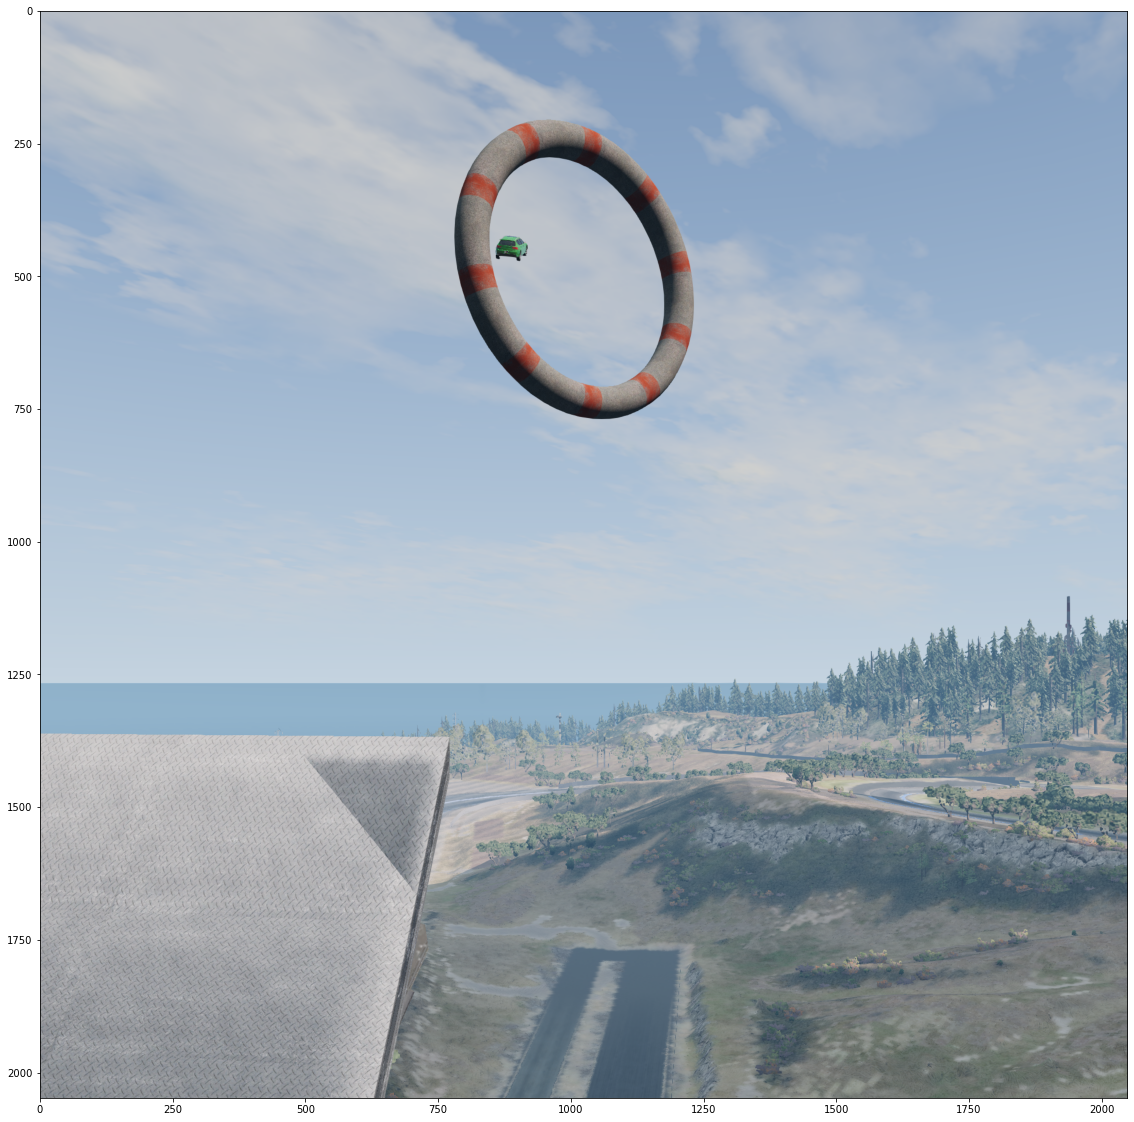

In [4]:
if tech_version:
    plt.figure(figsize=(20, 20))
    imshow(np.asarray(frames['colour'].convert('RGB')))